In [1]:
import uproot
import numpy as np
import numba
import matplotlib.pyplot as plt
import hist as hephist
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
from sklearn.gaussian_process import GaussianProcessRegressor 
import scipy.optimize
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
import pandas as pd
import scipy.stats
from scipy import integrate as intg 
from scipy.integrate import trapz, simps, quad
import math
from uncertainties import ufloat
%matplotlib widget

In [2]:
from  help_class import model
import mplhep as hep

Welcome to JupyROOT 6.24/06


# GMC Validation at different pT and XF bins

In [3]:
#file = uproot.open("../../root_files/result_mcDY_dump.root")
#file=uproot.open("merged_flask_result.root")

file = uproot.open("/Users/abinashpun/E906_projects/root_files/mc_drellyan_LH2_M027_S001_messy_occ_pTxFweight_v2.root")
result_mc = file['Tree']
df_mc = result_mc.arrays(library="pd") #to get as pandas data frame
df_mc.head()

,runID,spillID,eventID,dimuonID,mass,px1,py1,pz1,px2,py2,...,mxT,mxF,mdpx,mdpy,mdpz,sigWeight,D1,D2,D3,ReWeight
0,1.0,1.0,5.0,1.0,6.463176,-3.106632,-2.129862,33.278114,2.067885,1.719356,...,0.379466,0.390696,-0.374616,0.088753,80.563202,2.231384,62,43,62,3.605462
1,1.0,1.0,9.0,2.0,7.927976,-2.481393,-2.275653,48.188400,3.935459,2.273817,...,0.329666,0.737642,0.841443,-0.306283,103.453140,0.150724,230,203,250,0.173923
2,1.0,1.0,10.0,3.0,5.726212,-1.971867,-0.151348,25.555805,3.504016,2.311271,...,0.261206,0.587924,-0.851051,1.370690,89.148918,5.925457,349,331,320,3.031287
3,1.0,1.0,11.0,4.0,4.913350,-2.263586,-1.909082,60.912781,2.018088,0.629279,...,0.121771,0.901063,-0.201091,-1.233798,111.599670,1.113330,180,227,257,0.673723
4,1.0,1.0,16.0,5.0,6.903460,-4.157282,1.050577,29.506681,2.667121,-0.767817,...,0.446951,0.011997,0.197126,-0.331308,54.780998,14.544341,290,326,331,18.990019


## Cuts

In [5]:
pT_threshold = 1.
xF_threshold = 0.65
mass_threshold = 0.0

#mass_mask = df_mc['dim_mass']>mass_threshold

# pT_low_mask = (df_mc['dim_mass']>mass_threshold) & (df_mc['dim_pT']<pT_threshold)
# pT_high_mask = (df_mc['dim_mass']>mass_threshold) & (df_mc['dim_pT']>pT_threshold)

# xF_low_mask = (df_mc['dim_mass']>mass_threshold) & (df_mc['dim_pT']<xF_threshold)
# xF_high_mask = (df_mc['dim_mass']>mass_threshold) & (df_mc['dim_pT']>xF_threshold)

loose_cuts = (df_mc['chisq_dimuon']<20.) & df_mc['mass']>mass_threshold #& (((df_mc['negRoad'])*(df_mc['posRoad']))<0.)

df_mc['pT'] = np.sqrt(df_mc['dpx']*df_mc['dpx']+df_mc['dpy']*df_mc['dpy']) 

physical_xF = (df_mc['xF'] > -2.) & (df_mc['xF'] < 2.)

df_mc['xF'] = df_mc['xF'][physical_xF]
pT_low_mask =  (df_mc['pT']<pT_threshold) & (loose_cuts) & (physical_xF)
pT_high_mask = (df_mc['pT']>pT_threshold) & (loose_cuts) & (physical_xF)

xF_low_mask =  (df_mc['xF']<xF_threshold) & (loose_cuts) & (physical_xF)
xF_high_mask = (df_mc['xF']>xF_threshold)  & (loose_cuts) & (physical_xF)


In [6]:
# pT = df_mc['dim_pT'][mass_mask]

# hpT, bins = np.histogram(pT, bins=200, weights = df_mc['weight'][mass_mask])
# f, ax = plt.subplots()
# hep.histplot(hpT, bins, yerr=True,)

## Functions; plot, creating sideband, gpr plot

In [7]:
xmin = 1. # GeV; lower limit of mass
xmax = 9. # GeV; higher limit of mass
step_size = .1 # GeV
    

def plot_data(data, wt):

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centers = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,bin_data_x = np.histogram(data, weights = wt,
                          bins=bin_edges ) # histogram the data
    
    data_x_errors = np.sqrt(np.histogram(data, bins=bin_data_x, weights=(wt)**2)[0])

    fig = plt.figure(figsize=(10,6))
    plt.errorbar(bin_centers,data_x,yerr=data_x_errors,linewidth=2,color="black",fmt='o',label="pt <1.0")
    #plt.plot(bin_edges[0:-1], data_x,label="Data", color="black")
    plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 
    #plt.yscale('log')
    #plt.legend()
    #plt.legend(prop={'size':15})
    #plt.ylim(bottom=-0.25e7)
    plt.grid(True)
    return data_x, bin_centers, data_x_errors


def create_side_band_data(sideband_,data_,bin_centers_,data_errors_):
    data=np.column_stack((np.array(bin_centers_),np.array(data_), np.array(data_errors_)))
    mask = (((sideband_[0] <= data[:,0]) & (data[:,0] <= sideband_[1])) | ((sideband_[2] <= data[:,0]) & (data[:,0] <= sideband_[3])))
    data_train = data[mask]
    X_train=data_train[:,0]
    Y_train=data_train[:,1]
    Y_train_error=data_train[:,2]
    return X_train, Y_train, Y_train_error


def plot_data_gpr(bin_centers, data_x, data_x_errors, Y_pred, sigma):
    fig = plt.figure(figsize=(10,7))
    plt.errorbar(bin_centers,data_x,yerr=data_x_errors,linewidth=2,color="black",fmt='o',label="xF > 0.5 GeV")
    #plt.errorbar(bin_centers,data_x,yerr=data_x_errors,linewidth=2,color="black",fmt='o')
    pred_axes = plt.gca()
    pred_axes.plot(bin_centers,Y_pred, label="Mean prediction from GPR",color='orange',linestyle='--',linewidth=2)
    pred_axes.fill_between(
        bin_centers.ravel(),
        Y_pred - 1.96 * sigma,
        Y_pred + 1.96 * sigma,
        alpha=0.5,
        label=r"95% confidence interval",
        color='orange'
    )
    plt.legend()
    plt.legend(prop={'size':15})
    plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                            x=1, horizontalalignment='right', 
                            fontsize=18 ) 
    plt.grid(True)
    #plt.ylim(bottom=-0.25e7)
    plt.axvspan(sideband[0], sideband[1], alpha=0.2, color='red')
    plt.axvspan(sideband[2], sideband[3], alpha=0.2, color='red')
    #plt.show()
    #plt.yscale('log')


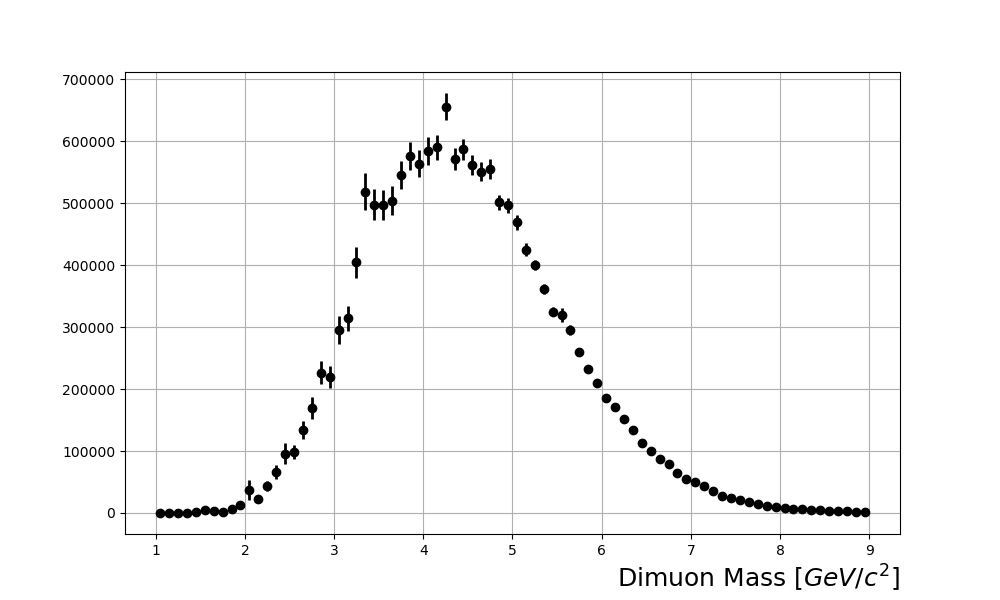

In [8]:
data_mass=df_mc['mass']
wt = df_mc['sigWeight']

data_x, bin_centers, data_x_errors = plot_data(data_mass,wt)

In [9]:
sideband = np.array([1.8, 2.5, 4.5, 7.0])
X_train, Y_train, Y_train_error = create_side_band_data(sideband,data_x, bin_centers, data_x_errors)

In [10]:
sideband_kernel = C(5000.0, (1e-10, 1e15))*RBF(length_scale=5, length_scale_bounds=(1e-4, 1e15))

gaussian_process = GaussianProcessRegressor(kernel=sideband_kernel, alpha=Y_train_error**2, n_restarts_optimizer=200)
gaussian_process.fit(np.atleast_2d(X_train).T, Y_train)
gaussian_process.kernel_
f"Log-likelihood: {gaussian_process.log_marginal_likelihood(gaussian_process.kernel_.theta):.3f}"

'Log-likelihood: -347.186'

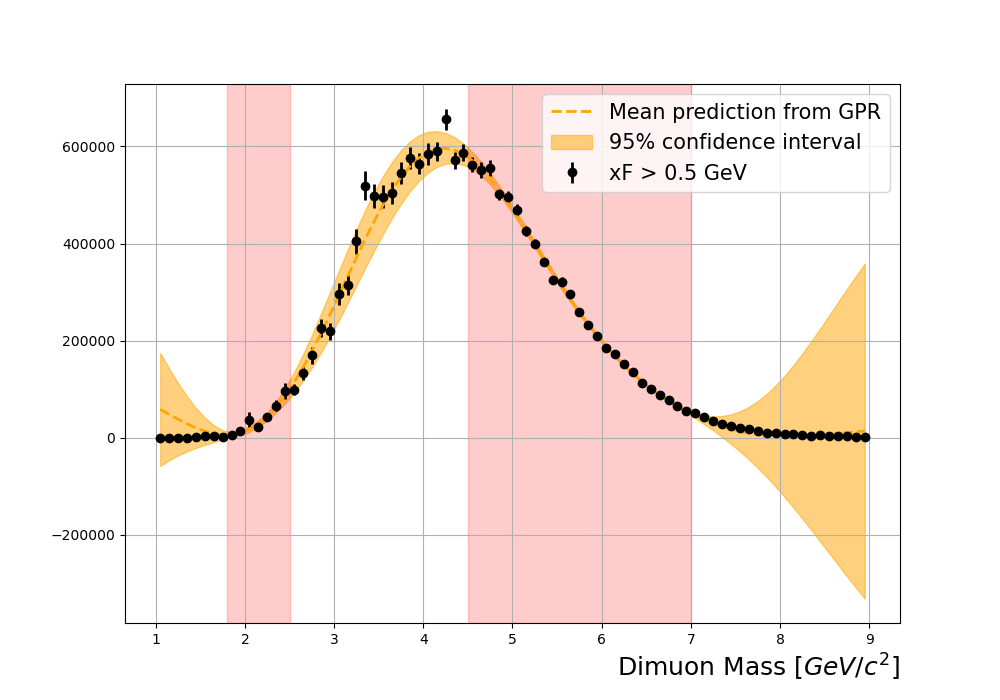

In [11]:
Y_pred, sigma = gaussian_process.predict(np.atleast_2d(bin_centers).T, return_std=True)
Y_pred, cov_matrix = gaussian_process.predict(np.atleast_2d(bin_centers).T, return_cov=True)

sigma2 = np.sum(cov_matrix, axis=0)
gpr_error = np.sqrt(abs(sigma2))
plot_data_gpr(bin_centers, data_x, data_x_errors, Y_pred, sigma)

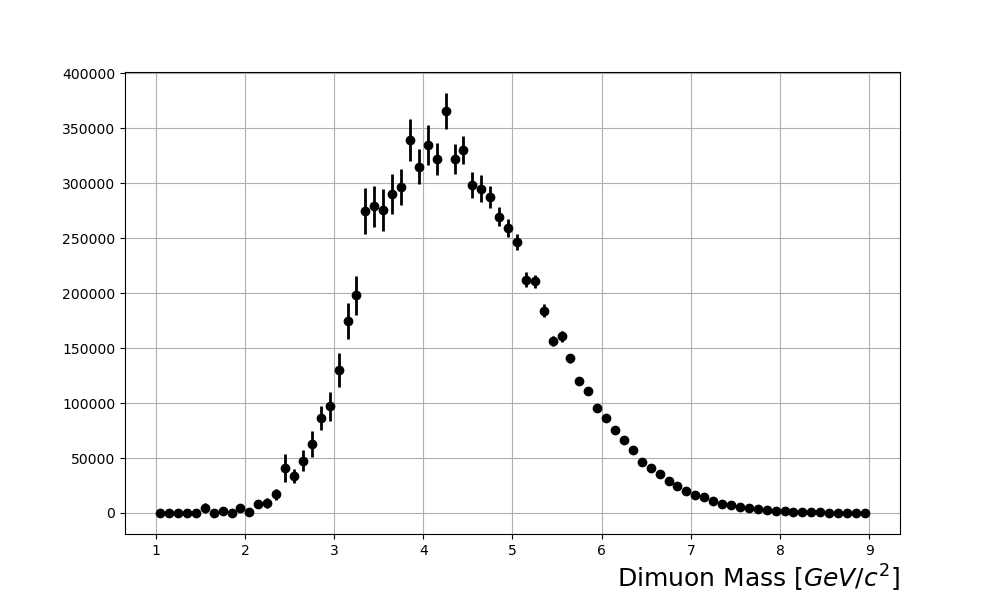

In [12]:
data_mass_lowpt=df_mc['mass'][pT_low_mask]
wt_lowpt = df_mc['sigWeight'][pT_low_mask]

data_x, bin_centers, data_x_errors = plot_data(data_mass_lowpt,wt_lowpt)


In [13]:
# h, bins = np.histogram(data_mass, bins=20, weights = wt)
# f, ax = plt.subplots()
# hep.histplot(h, bins, yerr=True,)
# #ax.set_yscale('log')

In [14]:
sideband = np.array([1.8, 2.5, 4.5, 7.])
X_train, Y_train, Y_train_error = create_side_band_data(sideband,data_x, bin_centers, data_x_errors)

In [15]:
sideband_kernel = C(5000.0, (1e-10, 1e15))*RBF(length_scale=5, length_scale_bounds=(1e-4, 1e15))

gaussian_process = GaussianProcessRegressor(kernel=sideband_kernel, alpha=Y_train_error**2, n_restarts_optimizer=200)
gaussian_process.fit(np.atleast_2d(X_train).T, Y_train)
gaussian_process.kernel_
f"Log-likelihood: {gaussian_process.log_marginal_likelihood(gaussian_process.kernel_.theta):.3f}"

'Log-likelihood: -329.842'

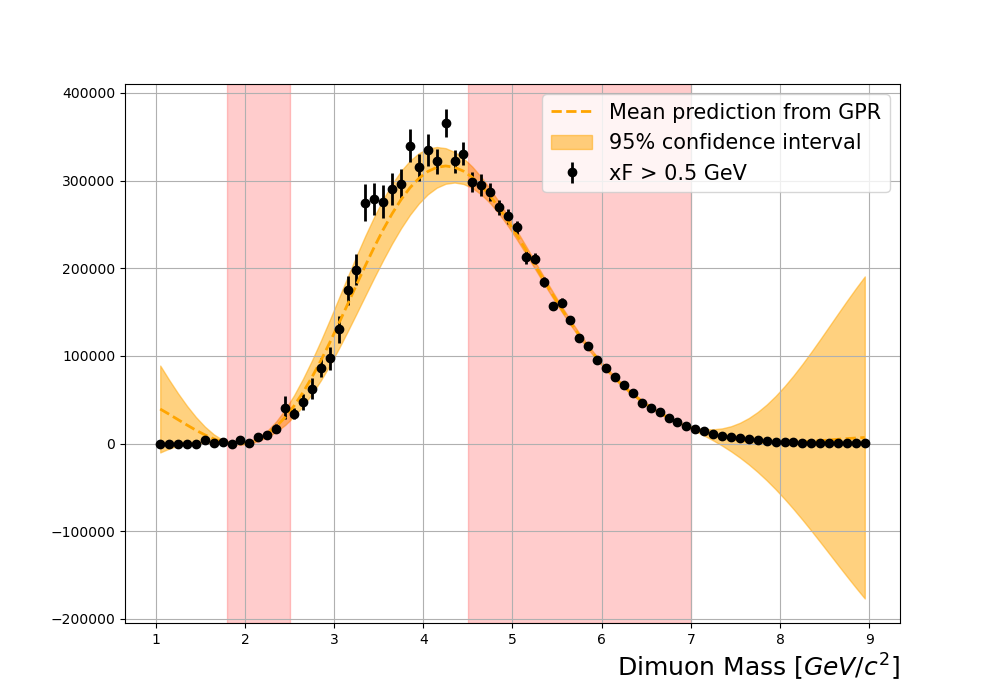

In [16]:
Y_pred, sigma = gaussian_process.predict(np.atleast_2d(bin_centers).T, return_std=True)
Y_pred, cov_matrix = gaussian_process.predict(np.atleast_2d(bin_centers).T, return_cov=True)

sigma2 = np.sum(cov_matrix, axis=0)
gpr_error = np.sqrt(abs(sigma2))
plot_data_gpr(bin_centers, data_x, data_x_errors, Y_pred, sigma)

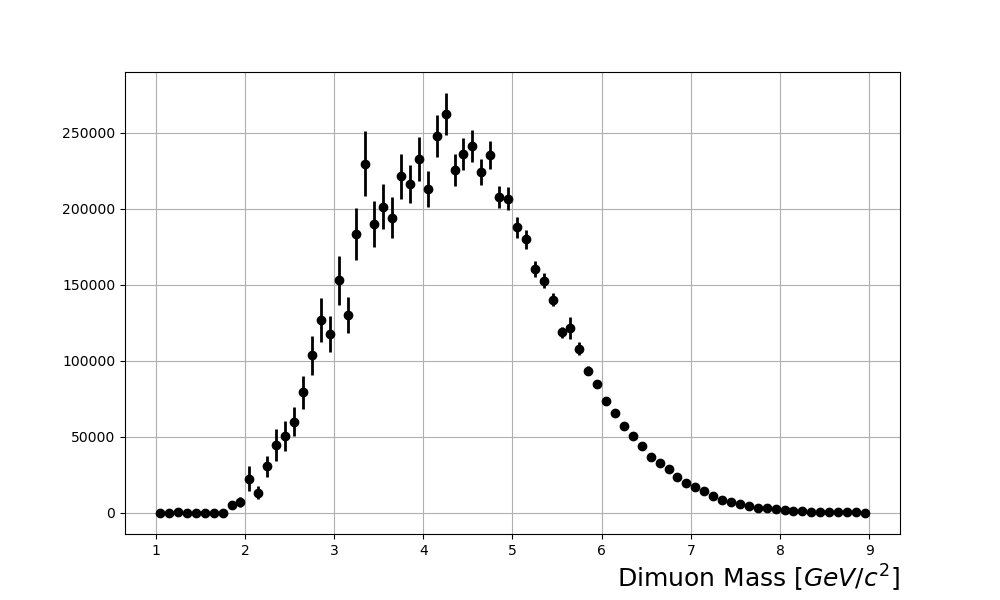

In [17]:
data_mass_highpT=df_mc['mass'][pT_high_mask]
wt_highpT = df_mc['sigWeight'][pT_high_mask]

data_x_highpT, bin_centers_highpT, data_x_errors_highpT = plot_data(data_mass_highpT,wt_highpT)

In [18]:
sideband = np.array([1.8, 2.5, 4.5, 7.])
X_train_highpT, Y_train_highpT, Y_train_error_highpT = create_side_band_data(sideband,data_x_highpT, bin_centers_highpT, data_x_errors_highpT)

In [19]:
sideband_kernel_highpT = C(5000.0, (1e-10, 1e15))*RBF(length_scale=5, length_scale_bounds=(1e-4, 1e15))

gaussian_process_highpT = GaussianProcessRegressor(kernel=sideband_kernel_highpT, alpha=Y_train_error_highpT**2, n_restarts_optimizer=200)
gaussian_process_highpT.fit(np.atleast_2d(X_train_highpT).T, Y_train_highpT)
gaussian_process_highpT.kernel_
f"Log-likelihood: {gaussian_process.log_marginal_likelihood(gaussian_process_highpT.kernel_.theta):.3f}"

'Log-likelihood: -331.056'

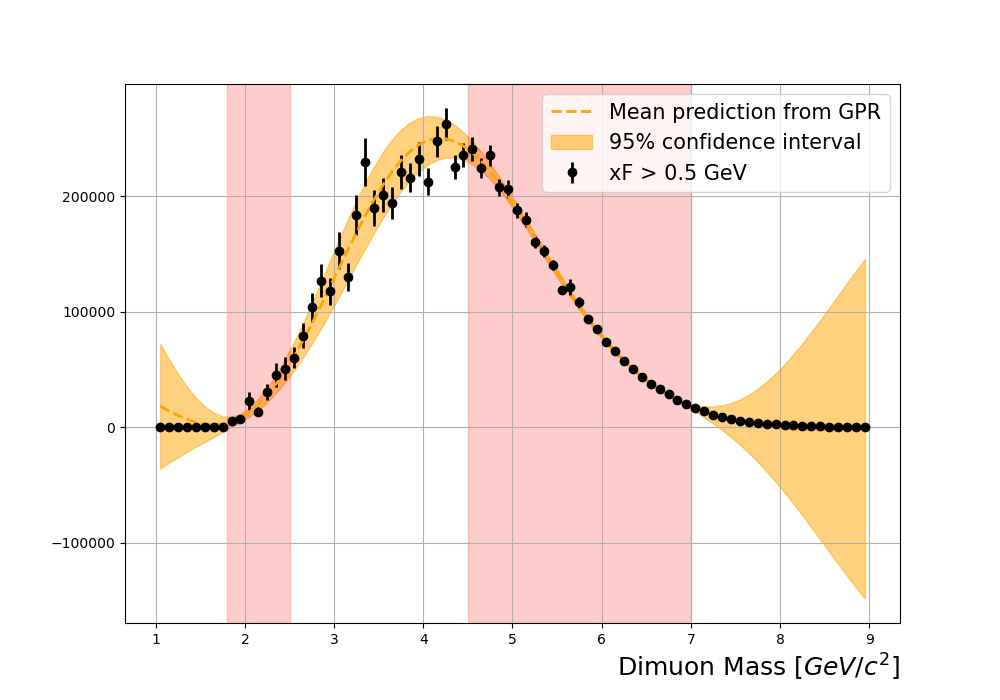

In [20]:
Y_pred_highpT, sigma_highpT = gaussian_process_highpT.predict(np.atleast_2d(bin_centers_highpT).T, return_std=True)
Y_pred_highpT, cov_matrix_highpT = gaussian_process_highpT.predict(np.atleast_2d(bin_centers_highpT).T, return_cov=True)

sigma2_highpT = np.sum(cov_matrix_highpT, axis=0)
gpr_error_highpT = np.sqrt(abs(sigma2_highpT))
plot_data_gpr(bin_centers_highpT, data_x_highpT, data_x_errors_highpT, Y_pred_highpT, sigma_highpT)

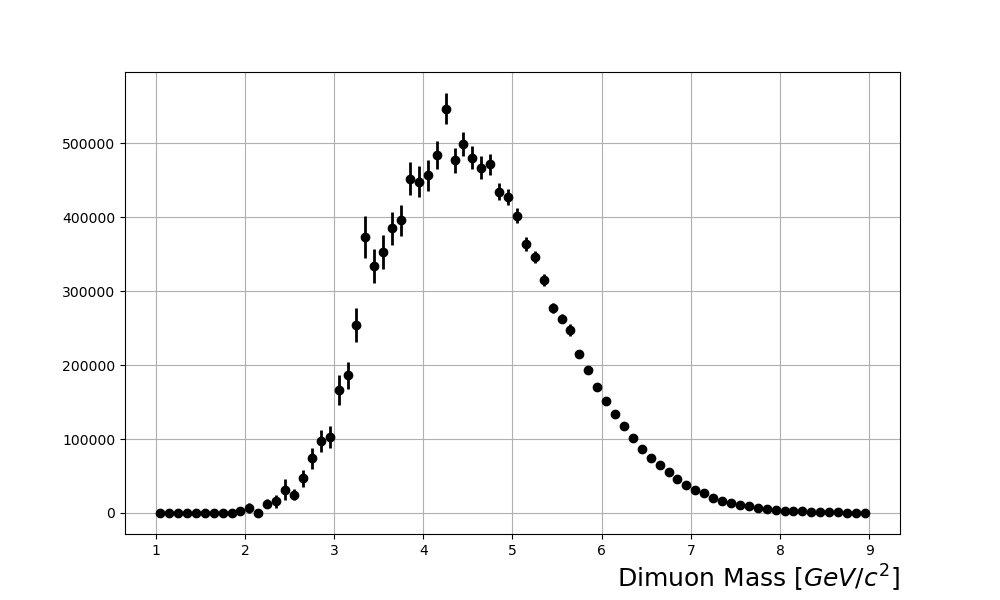

In [21]:
data_mass_lowxF=df_mc['mass'][xF_low_mask]
wt_lowxF = df_mc['sigWeight'][xF_low_mask]

data_x_lowxF, bin_centers_lowxF, data_x_errors_lowxF = plot_data(data_mass_lowxF,wt_lowxF)

In [22]:
sideband = np.array([1.8, 2.5, 4.5, 6.5])
X_train_lowxF, Y_train_lowxF, Y_train_error_lowxF = create_side_band_data(sideband,data_x_lowxF, bin_centers_lowxF, data_x_errors_lowxF)

In [23]:
sideband_kernel_lowxF = C(50000.0, (1e-10, 1e15))*RBF(length_scale=5, length_scale_bounds=(1e-4, 1e15))

gaussian_process_lowxF = GaussianProcessRegressor(kernel=sideband_kernel_lowxF, alpha=Y_train_error_lowxF**2, n_restarts_optimizer=200)
gaussian_process_lowxF.fit(np.atleast_2d(X_train_lowxF).T, Y_train_lowxF)
gaussian_process_lowxF.kernel_
f"Log-likelihood: {gaussian_process.log_marginal_likelihood(gaussian_process_lowxF.kernel_.theta):.3f}"

'Log-likelihood: -331.598'

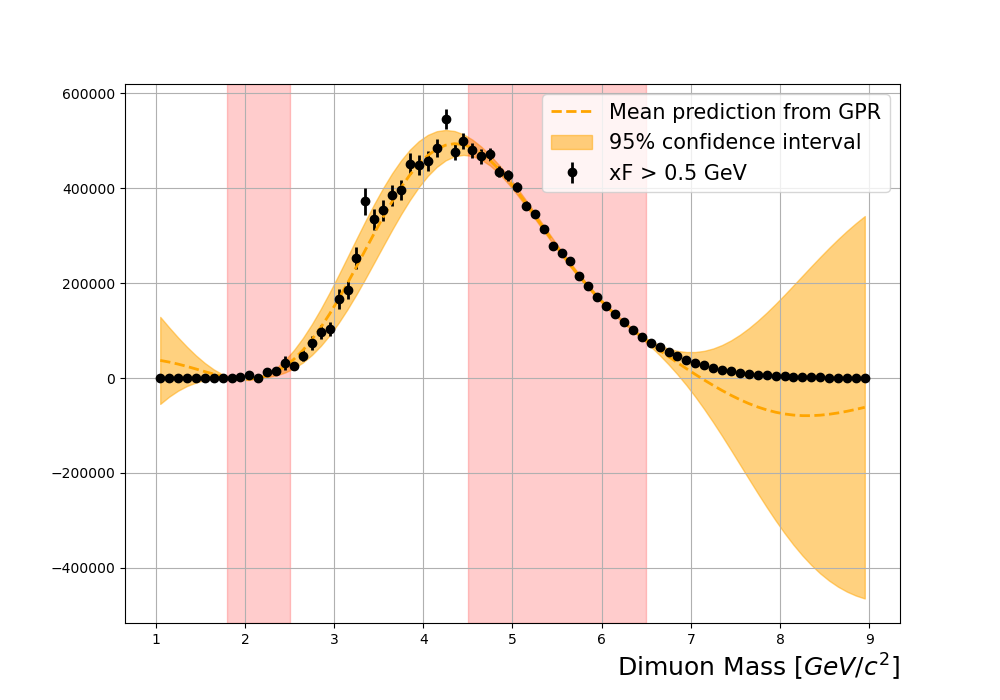

In [24]:
Y_pred_lowxF, sigma_lowxF = gaussian_process_lowxF.predict(np.atleast_2d(bin_centers_lowxF).T, return_std=True)
Y_pred_lowxF, cov_matrix_lowxF = gaussian_process_lowxF.predict(np.atleast_2d(bin_centers_lowxF).T, return_cov=True)

sigma2_lowxF = np.sum(cov_matrix_lowxF, axis=0)
gpr_error_lowxF = np.sqrt(abs(sigma2_lowxF))
plot_data_gpr(bin_centers_lowxF, data_x_lowxF, data_x_errors_lowxF, Y_pred_lowxF, sigma_lowxF)

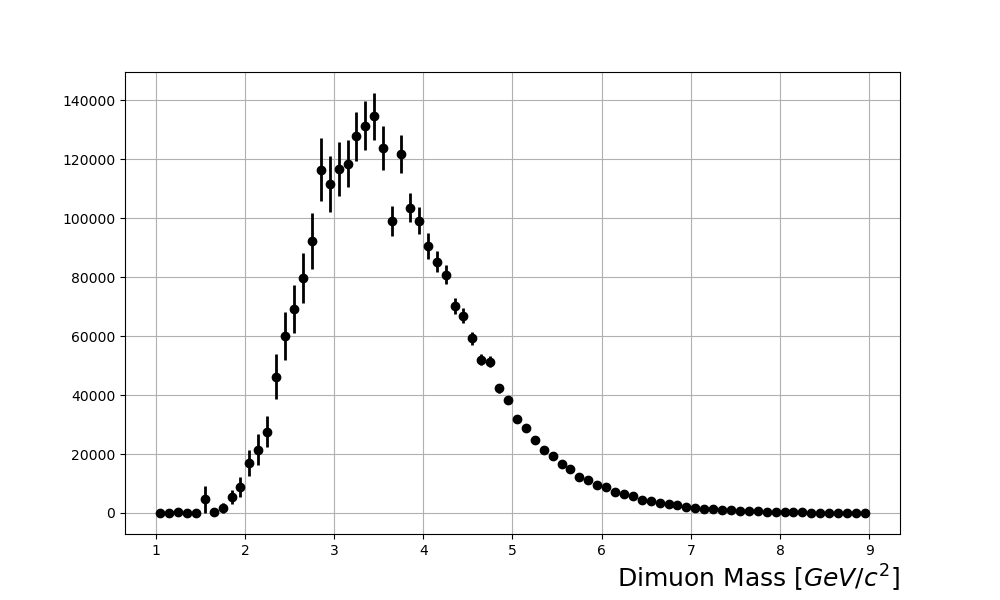

In [25]:
data_mass_highxF=df_mc['mass'][xF_high_mask]
wt_highxF = df_mc['sigWeight'][xF_high_mask]

data_x_highxF, bin_centers_highxF, data_x_errors_highxF = plot_data(data_mass_highxF,wt_highxF)

In [26]:
X_train_highxF, Y_train_highxF, Y_train_error_highxF = create_side_band_data(sideband,data_x_highxF, bin_centers_highxF, data_x_errors_highxF)

In [27]:
sideband_kernel_highxF = C(80000.0, (1e-10, 1e25))*RBF(length_scale=1000, length_scale_bounds=(1e-4, 1e35))
#sideband_kernel_highxF = C(50000.0, (1e-10, 1e15))*ExpSineSquared(length_scale=5, length_scale_bounds=(1e-4, 1e15))
gaussian_process_highxF = GaussianProcessRegressor(kernel=sideband_kernel_highxF, alpha=Y_train_error_highxF**2, n_restarts_optimizer=1000)
gaussian_process_highxF.fit(np.atleast_2d(X_train_highxF).T, Y_train_highxF)
gaussian_process_highxF.kernel_



/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


5.08e+04**2 * RBF(length_scale=1.44)

In [28]:
f"Log-likelihood: {gaussian_process.log_marginal_likelihood(gaussian_process_highxF.kernel_.theta):.3f}"

'Log-likelihood: -349.995'

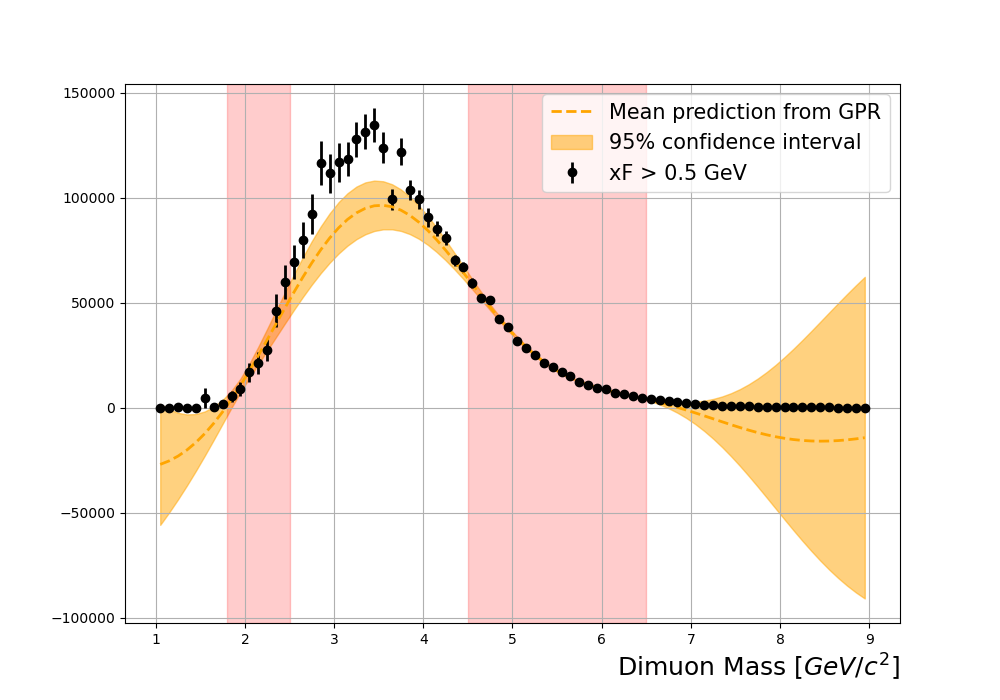

In [29]:
Y_pred_highxF, sigma_highxF = gaussian_process_highxF.predict(np.atleast_2d(bin_centers_highxF).T, return_std=True)
Y_pred_highxF, cov_matrix_highxF = gaussian_process_highxF.predict(np.atleast_2d(bin_centers_highxF).T, return_cov=True)

sigma2_highxF = np.sum(cov_matrix_highxF, axis=0)
gpr_error_highxF = np.sqrt(abs(sigma2_highxF))
plot_data_gpr(bin_centers_highxF, data_x_highxF, data_x_errors_highxF, Y_pred_highxF, sigma_highxF)